# A Sentiment Analysis of MLB Performance

In [1]:
#Install reqired libraries
!pip install beautifulsoup4 requests
!pip install tqdm

In [2]:
#Import required libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import numpy as np
import seaborn as sn

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from tqdm import tqdm

##### The first step is to scrape the text from the blog posts from the mlbtraderumors.com website. The posts include text, dates posted, and the authors name, all of which will be scraped before storing into a dataframe to use and start the text analysis.

# Acquire Text Data

In [3]:
def scrape_website(url, file_path):
    # Send a GET request to the website
    response = requests.get(url)

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")

    # Find all the news article elements
    articles = soup.find_all("article")

    # Create lists to store the extracted values
    titles = []
    authors = []
    dates = []
    contents = []

    # Iterate over the articles and extract the text
    with open(file_path, "w", encoding="utf-8") as file:
        for article in articles:
            # Extract the article title
            title_element = article.find("h2")
            title = title_element.text.strip() if title_element else ""
            titles.append(title)

            # Extract the article author
            author_element = article.find("span", class_="entry-author")
            author = author_element.text.strip() if author_element else ""
            authors.append(author)

            # Extract the article date
            date_element = article.find("time", class_="entry-time")
            date = date_element.text.strip() if date_element else ""
            dates.append(date)

            # Extract the article content
            content_element = article.find("div", class_="entry-content")
            content = content_element.text.strip() if content_element else ""
            contents.append(content)

            # Write the title and content to the file
            file.write("Title: " + title + "\n")
            file.write("Author: " + author + "\n")
            file.write("Date: " + date + "\n")
            file.write("Content: " + content + "\n")
            file.write("---\n")

    # Create a DataFrame from the extracted values
    data = {
        "Title": titles,
        "Author": authors,
        "Date": dates,
        "Content": contents
    }

    df = pd.DataFrame(data)

    # Drop rows without content
    df.dropna()

    return df

# Oakland Athletcis Data Collection and Cleaning

In [4]:
# URL of the website to scrape
url = "https://www.mlbtraderumors.com/oakland-athletics?show=all"
file_path = "C:/Users/andre/OneDrive/Project/mlbtraderumors_oakland_athletics_articles1.txt"

# Scrape the website, write the scraped text to a file, and get the head of the DataFrame
df = scrape_website(url, file_path)
df.head()

,Title,Author,Date,Content
0,Dick Hall Passes Away,Darragh McDonald,"June 19, 2023",The Orioles have announced that former major l...
1,A’s Acquire Yacksel Rios,Nick Deeds,"June 18, 2023",6:56 PM: As noted by Justin Toscano of the Atl...
2,Report: Red Sox Interested In Aledmys Diaz,Mark Polishuk,"June 18, 2023",The Red Sox are looking to acquire an infielde...
3,A's To Stay In Oakland Through 2024 Season,Nick Deeds,"June 17, 2023",While the Athletics seem more likely than ever...
4,"A’s Select Tyler Wade, Place Kevin Smith On 10...",Mark Polishuk,"June 17, 2023",The Athletics placed infielder Kevin Smith on ...


In [5]:
# Change the Data column to a datetime object:
df['Date'] = pd.to_datetime(df['Date'], format="%B %d, %Y", errors= 'coerce')

In [6]:
df.dtypes

Title              object
Author             object
Date       datetime64[ns]
Content            object
dtype: object

In [7]:
# Check for missing values
df.isna().sum()

Title       0
Author      0
Date       30
Content     0
dtype: int64

In [8]:
len(df)

1030

In [9]:
df = df.dropna()
df

,Title,Author,Date,Content
0,Dick Hall Passes Away,Darragh McDonald,2023-06-19,The Orioles have announced that former major l...
1,A’s Acquire Yacksel Rios,Nick Deeds,2023-06-18,6:56 PM: As noted by Justin Toscano of the Atl...
2,Report: Red Sox Interested In Aledmys Diaz,Mark Polishuk,2023-06-18,The Red Sox are looking to acquire an infielde...
3,A's To Stay In Oakland Through 2024 Season,Nick Deeds,2023-06-17,While the Athletics seem more likely than ever...
4,"A’s Select Tyler Wade, Place Kevin Smith On 10...",Mark Polishuk,2023-06-17,The Athletics placed infielder Kevin Smith on ...
...,...,...,...,...
995,How Jonathan Lucroy Has Helped The A's,Mark Polishuk,2018-10-03,Jonathan Lucroy didn’t contribute much at the ...
996,A's To Start Liam Hendriks In Wild-Card Game,Connor Byrne,2018-10-02,The Yankees and Athletics have named their sta...
997,Andrew Triggs Undergoes Thoracic Outlet Surgery,Jeff Todd,2018-09-28,Sept. 28: The A’s announced tonight that Trigg...
998,Athletics Plan To Discuss Bob Melvin Extension...,Steve Adams,2018-09-28,The Athletics have been baseball’s most unexpe...


## Import data on the Oakland Athletics from baseball-reference.com.

https://www.baseball-reference.com/teams/OAK/attend.shtml

In [24]:
# URL of the webpage to scrape
url = "https://www.baseball-reference.com/teams/OAK/attend.shtml"

# Read the HTML table into a list of DataFrames
tables = pd.read_html(url)

# Select the table of interest (index 0 in this case)
table = tables[0]

# Save the DataFrame as a CSV file
file_path = "C:/Users/andre/OneDrive/Project/MLB_data/athletics_statistics.csv"
table.to_csv(file_path, index=False, header=True)

print("Data saved to", file_path)

Data saved to C:/Users/andre/OneDrive/Project/MLB_data/athletics_statistics.csv


In [25]:
path = "C:/Users/andre/OneDrive/Project/MLB_data/"

athletics_df = pd.DataFrame(pd.read_csv(path + 'athletics_statistics.csv'))
athletics_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Oakland Athletics,AL West,19,55,5,NaN,368146.0,9688.0,15th of 15,"$51,230,000",94,92,RingCentral Coliseum
1,2022,Oakland Athletics,AL West,60,102,5,NaN,787902.0,9849.0,15th of 15,"$50,248,334",95,93,RingCentral Coliseum
2,2021,Oakland Athletics,AL West,86,76,3,NaN,701430.0,8660.0,15th of 15,"$94,555,834",95,95,RingCentral Coliseum
3,2020,Oakland Athletics,AL West,36,24,1,Lost ALDS (3-1),NaN,NaN,11th of 15,"$85,683,333",94,96,Oakland-Alameda County Coliseum
4,2019,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1670734.0,20626.0,10th of 15,"$102,935,833",93,94,Oakland-Alameda County Coliseum


In [26]:
athletics_df= athletics_df[athletics_df['Year'] > 2004]
athletics_df

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Oakland Athletics,AL West,19,55,5,NaN,368146.0,9688.0,15th of 15,"$51,230,000",94,92,RingCentral Coliseum
1,2022,Oakland Athletics,AL West,60,102,5,NaN,787902.0,9849.0,15th of 15,"$50,248,334",95,93,RingCentral Coliseum
2,2021,Oakland Athletics,AL West,86,76,3,NaN,701430.0,8660.0,15th of 15,"$94,555,834",95,95,RingCentral Coliseum
3,2020,Oakland Athletics,AL West,36,24,1,Lost ALDS (3-1),NaN,NaN,11th of 15,"$85,683,333",94,96,Oakland-Alameda County Coliseum
4,2019,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1670734.0,20626.0,10th of 15,"$102,935,833",93,94,Oakland-Alameda County Coliseum
5,2018,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1573616.0,19427.0,13th of 15,"$69,883,333",97,97,Oakland-Alameda County Coliseum
6,2017,Oakland Athletics,AL West,75,87,5,NaN,1475721.0,18219.0,14th of 15,"$51,560,000",95,95,Oakland-Alameda County Coliseum
7,2016,Oakland Athletics,AL West,69,93,5,NaN,1521506.0,18784.0,14th of 15,"$54,969,067",97,96,Oakland-Alameda County Coliseum
8,2015,Oakland Athletics,AL West,68,94,5,NaN,1768175.0,21829.0,12th of 15,"$64,016,001",97,97,O.co Coliseum
9,2014,Oakland Athletics,AL West,88,74,2,Lost ALWC (1-0),2003628.0,24736.0,10th of 15,"$89,160,900",97,98,O.co Coliseum


In [27]:
# Remove the dollar and comma signs from the following columns:
athletics_df['Est. Payroll'] = athletics_df['Est. Payroll'].replace({'\$':''}, regex = True)
athletics_df['Est. Payroll'] = athletics_df['Est. Payroll'].replace({'\,':''}, regex = True)
athletics_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Oakland Athletics,AL West,19,55,5,NaN,368146.0,9688.0,15th of 15,51230000,94,92,RingCentral Coliseum
1,2022,Oakland Athletics,AL West,60,102,5,NaN,787902.0,9849.0,15th of 15,50248334,95,93,RingCentral Coliseum
2,2021,Oakland Athletics,AL West,86,76,3,NaN,701430.0,8660.0,15th of 15,94555834,95,95,RingCentral Coliseum
3,2020,Oakland Athletics,AL West,36,24,1,Lost ALDS (3-1),NaN,NaN,11th of 15,85683333,94,96,Oakland-Alameda County Coliseum
4,2019,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1670734.0,20626.0,10th of 15,102935833,93,94,Oakland-Alameda County Coliseum


In [28]:
athletics_df['Est. Payroll'] = athletics_df['Est. Payroll'].astype(float)
athletics_df.dtypes

Year              int64
Tm               object
Lg               object
W                 int64
L                 int64
Finish            int64
Playoffs         object
Attendance      float64
Attend/G        float64
Rank             object
Est. Payroll    float64
PPF               int64
BPF               int64
Stadium          object
dtype: object

In [ ]:
#Add a column to define a binary output that has a 1 if the team has a winning record for the year, and 0 if they do not
athletics_df['success'] = (athletics_df['W'] / (athletics_df['W'] + athletics_df['L']) >= 0.5).astype(int)
athletics_df.head()

In [ ]:
# Count the number of successes and failures
success_counts = athletics_df['success'].value_counts()

# Create a bar plot
plt.bar(success_counts.index, success_counts.values)
plt.xticks(success_counts.index, ['Failure', 'Success'])
plt.xlabel('Success')
plt.ylabel('Count')
plt.title('Success Counts')

# Display the plot
plt.show()

In [ ]:
athletics_df.describe()

In [ ]:
# Plotting the data
# Convert columns to numpy arrays
year = np.array(athletics_df['Year'])
attendance = np.array(athletics_df['Attendance'])

plt.figure(figsize=(10, 6))

# Plotting Attendance over the years
plt.plot(year, attendance, marker='o')
plt.xlabel('Year')
plt.ylabel('Attendance')
plt.title('Attendance of Oakland Athletics over the Years')

# Display the plot
plt.show()

In [ ]:
# Plotting Wins over the years
year = np.array(athletics_df['Year'])
wins = np.array(athletics_df['W'])

plt.figure(figsize= (10,6))

# Plotting Attendance over the years
plt.plot(year, wins, marker='o')
plt.xlabel('Year')
plt.ylabel('Wins')
plt.title('Wins by Oakland Athletics over the Years')

# Display the plot
plt.show()

In [ ]:
# Plotting Payroll over the years
# Convert columns to numpy arrays
year = np.array(athletics_df['Year'])
payroll = np.array(athletics_df['Est. Payroll'])

plt.figure(figsize= (10,6))

# Plotting Attendance over the years
plt.plot(year, payroll, marker='o')
plt.xlabel('Year')
plt.ylabel('Payroll')
plt.title('Payroll of Oakland Athletics over the Years')

# Display the plot
plt.show()

In [ ]:
# Select numeric columns for correlation analysis
numeric_cols = ['W', 'L', 'Attendance', 'Attend/G', 'Est. Payroll', 'PPF', 'BPF', 'success']
numeric_df = athletics_df[numeric_cols]

# Correlation matrix
correlation = numeric_df.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

# Display the plot
plt.show()

                  Year         W         L    Finish  Attendance  Attend/G  \
Year          1.000000 -0.461594 -0.272585  0.356362   -0.739316 -0.740579   
W            -0.461594  1.000000  0.292504 -0.498125    0.702923  0.602977   
L            -0.272585  0.292504  1.000000  0.565745    0.085816 -0.029819   
Finish        0.356362 -0.498125  0.565745  1.000000   -0.541928 -0.535614   
Attendance   -0.739316  0.702923  0.085816 -0.541928    1.000000  0.983150   
Attend/G     -0.740579  0.602977 -0.029819 -0.535614    0.983150  1.000000   
Est. Payroll  0.214157  0.281505 -0.380622 -0.439569    0.160458  0.123188   
PPF          -0.479714  0.252063  0.252121 -0.070948    0.289479  0.288072   
BPF          -0.516398  0.396448  0.056171 -0.359041    0.512159  0.487661   

              Est. Payroll       PPF       BPF  
Year              0.214157 -0.479714 -0.516398  
W                 0.281505  0.252063  0.396448  
L                -0.380622  0.252121  0.056171  
Finish           -0.439

Text(0.5, 1.0, 'Correlation Matrix')

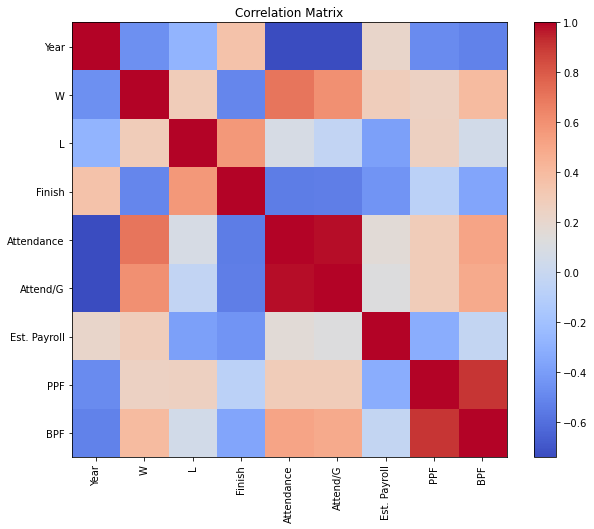

In [14]:
# Correlation matrix
correlation = athletics_df.corr()
print(correlation)

# Heatmap of correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(correlation, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation)), correlation.columns, rotation=90)
plt.yticks(range(len(correlation)), correlation.columns)
plt.title('Correlation Matrix')

#### Add column to analyze whether blog post occurred in a successful year or not.

In [ ]:
# Extract the year from the "Date" column in df DataFrame
df['Year'] = pd.to_datetime(df['Date']).dt.year

# Merge df and nats_df DataFrames on the "Year" column
merged_df = pd.merge(df, athletics_df[['Year', 'success']], on='Year', how='left')

# Add a new column 'Year_Successful' based on 'success' column
merged_df['Year_Successful'] = merged_df['success'].fillna(0).astype(int)

merged_df.head()

In [ ]:
len(merged_df)

# Cleaning the Data

In [ ]:
#Identify any noise in the data
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

In [ ]:
merged_df['Content'].apply

In [ ]:
pd.options.display.max_colwidth = 100 ###
# add new column to data frame
merged_df['impurity'] = merged_df['Content'].apply(impurity, min_len=10)

# get the top 3 records
merged_df[['Content', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

##### The steps above displays the highest impurity levels for the Athletics' data set. The impurity levels above are extremely low, being below 1% of all characters in each blog post appear suspicious.

# Character Normalization and Tokenization

In [ ]:
# Example function to normalize the text in the "Contents" column
def normalize_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove special characters and digits
    text = re.sub(r"[^a-zA-Z]", " ", text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    # Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

# Apply normalization to the "Contents" column
merged_df["Contents_Normalized"] = merged_df["Content"].apply(normalize_text)

# Print the head of the DataFrame with the normalized contents
merged_df[["Content", "Contents_Normalized"]].head()
 	

In [ ]:
merged_df['length'] = merged_df['Contents_Normalized'].str.len()
merged_df.head()

# Analyze descriptive statistics for text in dataframe.

In [ ]:
merged_df['length'].plot(kind='box', vert=False, figsize=(8, 1))

In [ ]:
merged_df['Title_length'] = merged_df['Title'].str.len()
merged_df['Title_length'].plot(kind='box', vert=False, figsize=(8, 1))

In [ ]:
merged_df['length'].plot(kind='hist', bins=30, figsize=(8,2))

In [ ]:
# Extract the month from the date and create a new column
merged_df['Month'] = merged_df['Date'].dt.month

# Plot the average post length
merged_df.groupby('Month').agg({'length': 'mean'}) \
  .plot(title="Avg. Post Length", ylim=(0,500), figsize=(6,2))


In [ ]:
def count_words(df, column='Contents_Normalized', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    tqdm.pandas() #initialize tqdm for progress bar
    df[column].apply(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [ ]:
freq_df = count_words(merged_df)
freq_df.head(5)

In [ ]:
#How many tokens are in the df?
len(freq_df)

In [ ]:
# top words with 10+ characters
count_words(merged_df, column='Content', 
            preprocess=lambda Content: re.findall(r"\w{10,}", Content)).head(5)

In [ ]:
ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')